In [1]:
import torch.nn as nn
import torch.nn.functional as F
from networks import *
from train_utils import *
import matplotlib.pyplot as plt

n_epochs = 42
batch_size = 128
batch_size_test = 1028
device = "cpu"

In [2]:
def trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_accuracy(model, stats):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.plot((1-stats["train_accuracy"])*100, label="training")
    ax.plot((1-stats["test_accuracy"])*100, label="test")
    ax.set_xlabel("epoch")
    ax.set_ylabel("error [%]")
    ax.legend(loc="upper right")
    best_epoch = np.argmax(stats["test_accuracy"])
    print("The minimum test error is {:1.2}% in epoch {}".format((1-stats["test_accuracy"][best_epoch])*100, best_epoch))
    print("The model has {:1.2} Million parameters".format(trainable_params(model)/1e6))
    
def plot_function_evals(stats):
    fe_forward = np.array(stats["specialised_metric"]["function_evals_forward"])
    fe_backward = np.array(stats["specialised_metric"]["function_evals_backward"])
    
    # fe_forward has dimensions [epochs, batches in epoch] 
    # however the first batch in each epoch also contains the number of function evaluatoins that occured during evaluating the accuracy
    # this is why I exclude the first batch
    
    fig, (ax2, ax1, ax3) = plt.subplots(1,3, figsize=(18,5))
    avg_forward = np.mean(fe_forward[:, 1:], axis=-1)
    avg_backward = np.mean(fe_backward[:, 1:], axis=-1)
    ax1.plot(avg_forward, label="forward")
    ax1.plot(avg_backward, label="backward")
    ax1.legend()
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("number")
    ax1.set_title("Average Function Evaluations")
    
    ax2.plot(fe_forward[0], label="forward")
    ax2.plot(fe_backward[0], label="backward")
    ax2.legend()
    ax2.set_title("Function Evaluations per Batch; First Epoch")
    ax2.set_xlabel("batch nr")
    ax2.set_ylabel("number")
    
    # scatterplot
    fe_forward_flatt = fe_forward[:, 1:].flatten()
    fe_backward_flatt = fe_backward[:, 1:].flatten()
    
    jitter1 = np.random.normal(0, 0.2, len(fe_forward_flatt)) 
    # just to make the quantity of points visible
    jitter2 = np.random.normal(0, 0.2, len(fe_backward_flatt))
    
    ax3.scatter(fe_forward_flatt+jitter1, fe_backward_flatt+jitter2, marker='.')
    ax3.plot([10, 50], [10, 50], c="black")
    ax3.set_xlabel("forward")
    ax3.set_ylabel("backward")
    



By default, the following code loads pretrained weights from the folder /cached_models. Deleting the folder results in the retraining of the models and the recreation of those weight files.

# Experiment 1 - Baseline Resnet
The first experiment reproduces the baseline given by "ResNet" in Table 1 of [1]. 

In [4]:
resnet_6 = nn.Sequential(*get_downsampling_layers(), *get_residual_blocks(6), *get_final_layers())
trained_resnet_6 = train_model_cached(resnet_6, file_path="cached_models/resnet6.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/resnet6.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer1): ReLU(inplace)
    (conv_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
    (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer2): ReLU(inplace)
    (conv_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  )
  (8): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=

The minimum test error is 0.39% in epoch 34
The model has 0.58 Million parameters


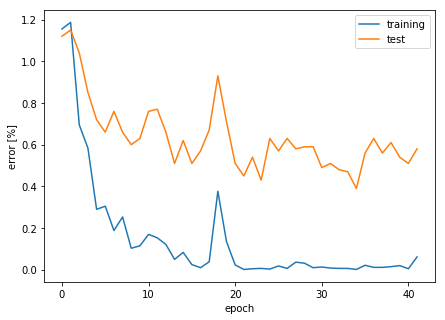

In [207]:
plot_accuracy(*trained_resnet_6)

The best test error of 0.39% almoust perfectly replicates the error of 0.41% reported in [1] (Table 1 "ResNet"). However, the network has 20k parameters less, then what is reported in [1]. Presumably the architecure or the kernel sizes are slighly different.

# Experiment 2 - Simpler ResNet
In addition to the previous model, I also try a residual neural network with only a single residual block instead of six. This model has the same number of parameters as the ODE-Network. Thus I believe it allows for a fairer comparisson. 

In [30]:
simple_resnet = nn.Sequential(*get_downsampling_layers(), *get_residual_blocks(1), *get_final_layers())
simple_resnet_trained = train_model_cached(simple_resnet, file_path="cached_models/simple_resnet1.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/simple_resnet1.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ResidualBlock(
    (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer1): ReLU(inplace)
    (conv_layer1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
    (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_layer2): ReLU(inplace)
    (conv_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  )
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

The minimum test error is 0.5% in epoch 26
The model has 0.21 Million parameters


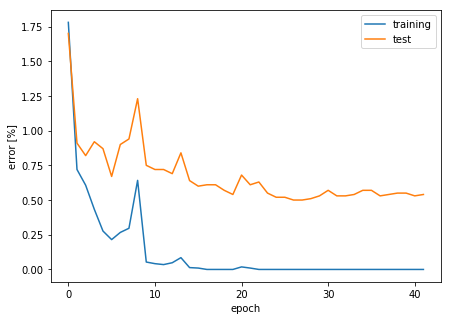

In [208]:
plot_accuracy(*simple_resnet_trained)

# Experiments 3 - Default ODE Network
The two following experiments replicate the entry for "ODE-Net" in Table 1 of [1]. The dynamics function in the ODE-Block consists of 2 convolutional layers with a ReLU nonlinearity and a normalisation each. For normalisation I try both Group-Normalisation [2] and Batch-Normalisation.    
The dynamics function depends on the current latent state $z(t)$ and the time $t$. The dependence on $t$ is realised by appending an additional channel that contains the current value of $t$ in each position. This is done before each of the 2 convolutions. 

Group normalisation turns out to be better suited and with it (Experiment 3.1) the network achieves a test error of 0.53% which is 0.11 percent points worse then the test error reported in [1]. 

## Experiment 3.1 - Default ODE Network (Group-Norm)
This experminet replicates the entry for "ODE-Net" in Table 1 of [1].  


In [32]:
standard_ode_group = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=True, norm_type="group"), device=device), *get_final_layers())
standard_ode_group_trained = train_model_cached(standard_ode_group, file_path="cached_models/ode_group.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/ode_group.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (dynamics_function): ConvolutionalDynamicsFunction(
      (norm_layer1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer1): ReLU(inplace)
      (conv_layer1): TimeDependentConv(
        (conv_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
      )
      (norm_layer2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer2): ReLU(inplace)
      (conv_layer2): TimeDependentConv(
        (conv_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=

#### Performance and Comparison to the Baseline

The minimum test error is 0.53% in epoch 10
The model has 0.21 Million parameters


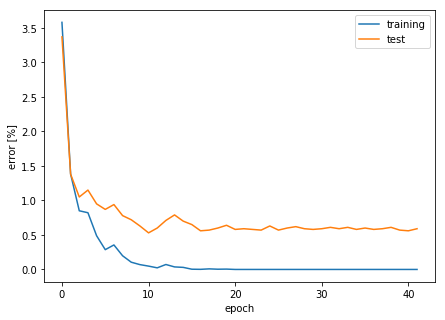

In [209]:
plot_accuracy(*standard_ode_group_trained)

In this experiment the network achieves a test error of 0.53% which is 0.11 percent points above the error reported for "ODE-Net" in Table 1 in [1]. Note, that this is also worse then the error achieved by the simple Res-Net in Experiment 2, which has the same number of parameters as the ODE-Net. This calls into question whether the ODE architecture is more parameter efficient then a simple residual architecture, which is claimed by [1]. 

#### Number of Function Evaluations

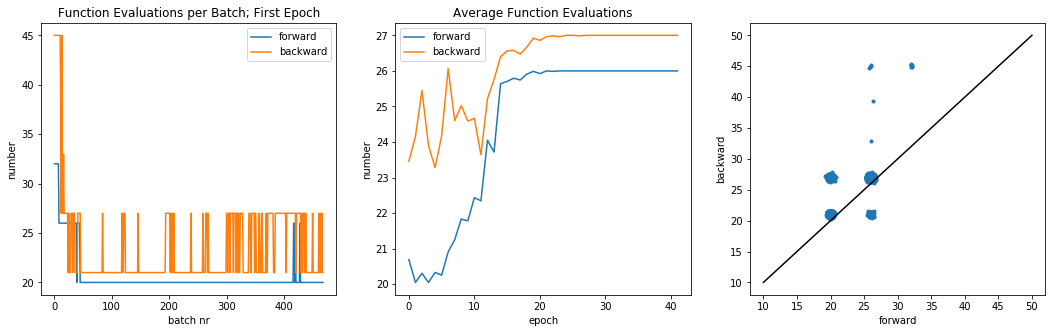

In [213]:
plot_function_evals(standard_ode_group_trained[1])

I also investigated the number of times, the dynamics function is evaluated by the black box ODE-Solver throughout training. The left subfigure shows the number of function evaluations for the forward and backward path for all batches within the first epoch.    
The central subfigure shows how the number of function evaluations per batch averaged within an epoch evolves through training.    
The right subfigure shows how the number of function evaluations in the forward path relate to the number in the backward path. All batches throughout all epochs are each displayed as a small dot. 

The central subfigure shows a trent of an increasing number of function evaluations as training progresses. The same was found in [1] and illustrated there in Figure 3d. 

In [1] Figure 3c it is also reported that the number of evaluations in the backward path tends to be lower then the number in the forward path. In my experiments I am not able to find the same effect. I find the number of evaluations in the backward path to be slightly higher then the number of evaluations in the forward path. This is shown by the central and the right subfigures above. 



## Experiment 3.2 - Default ODE Network (Batch Norm)

In [51]:
standard_ode_batch = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=True, norm_type="batch"), device=device), *get_final_layers())
standard_ode_batch_trained = train_model_cached(standard_ode_batch, file_path="cached_models/ode_batch.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/ode_batch.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (dynamics_function): ConvolutionalDynamicsFunction(
      (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_layer1): ReLU(inplace)
      (conv_layer1): TimeDependentConv(
        (conv_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
      )
      (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_layer2): ReLU(inplace)
      (conv_layer2): TimeDependentConv(
    

The minimum test error is 0.54% in epoch 31
The model has 0.21 Million Parameters


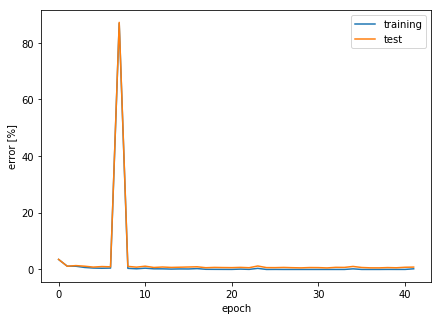

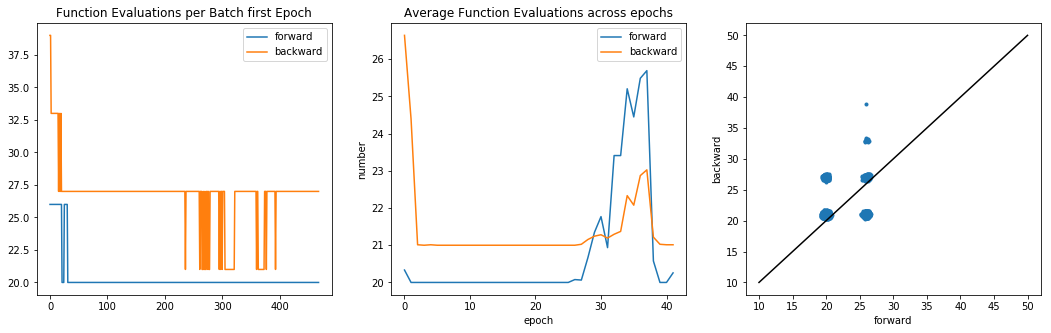

In [52]:
plot_accuracy(*standard_ode_batch_trained)
plot_function_evals(standard_ode_batch_trained[1])

In a second experiment I try batch-normalisation instead of group-normalisation within the dynamics function of the ODE-Block. I found this version to be less stable.   

# Experiment 4 - ODE Network without time-dependence 
Finally, I investigate the influence of including the time in the dynamics function of the ODE Block. In contrast to the Exeperiment 3 the dynamics function is independent of $t$ for the following architecture. I.e. $f(z(t), t, \theta) = f(z(t), \theta)$

In [35]:
no_time_ode_group = nn.Sequential(*get_downsampling_layers(), ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=False, norm_type="group"), device=device), *get_final_layers())
no_time_ode_group_trained = train_model_cached(no_time_ode_group, file_path="cached_models/no_time_ode_group.pth", batch_size=batch_size, test_batch_size=batch_size_test, epochs=n_epochs, verbosity=2, device=device)

Experiment cached_models/no_time_ode_group.pth
Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (dynamics_function): ConvolutionalDynamicsFunction(
      (norm_layer1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer1): ReLU(inplace)
      (conv_layer1): TimeDependentConv(
        (conv_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
      )
      (norm_layer2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu_layer2): ReLU(inplace)
      (conv_layer2): TimeDependentConv(
        (conv_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

The minimum test error is 0.58% in epoch 22
The model has 0.21 Million Parameters


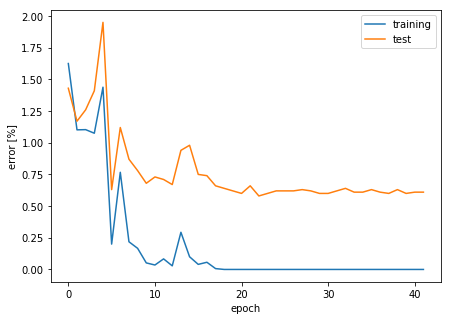

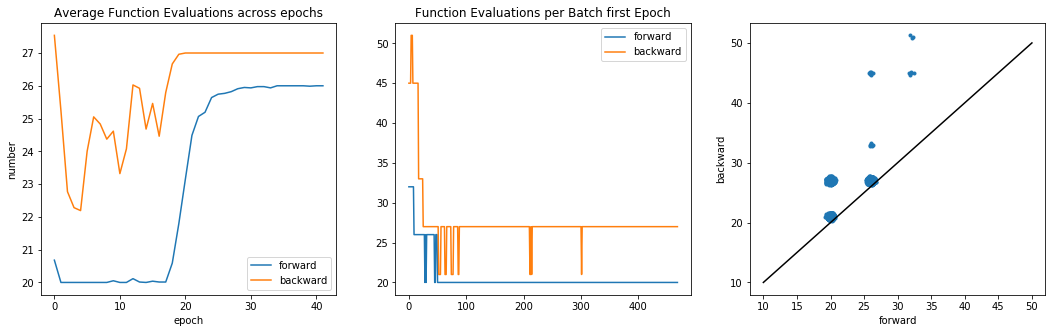

In [12]:
plot_accuracy(*no_time_ode_group_trained)
plot_function_evals(no_time_ode_group_trained[1])

With 0.58% test error, the performance slightly decreases when not allowing the dynamics function to be time dependent. However this effect does not seem to be very large. 

# Visualisations
Finally, I add two visualisations that illustrate the difference between the discrete feature transformation in the Res-Net case and the continuous feature transform in the ODE-Net case.

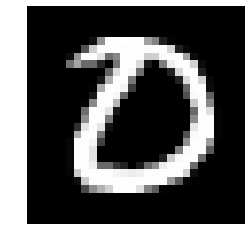

In [195]:
%matplotlib inline
train_loader, test_loader = get_data_loaders(batch_size=10)
for batch in test_loader:
    imgs, label = batch
    break
img = imgs[:1]
label = label[:1]
plt.imshow(img.detach().numpy()[0, 0, :, :], cmap="gray")
plt.axis('off')
pass


In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image



def reshape_time_course(timecourse):
    """reshapes the feature maps to a 2D picture"""
    n_times, n_channel, x_dim, y_dim = timecourse.shape
    assert(x_dim == y_dim)
    grid_size = int(np.sqrt(n_channel))
    
    outputsize = grid_size*x_dim+(grid_size-1)
    
    output = np.ones((n_times, outputsize, outputsize))*np.min(timecourse)
    for channel_id in range(n_channel):
        grid_y = channel_id // grid_size
        grid_x = channel_id % grid_size
        
        start_y = grid_y * x_dim + grid_y
        start_x = grid_x * x_dim + grid_x
        
        output[:, start_y:(start_y+x_dim), start_x:(start_x+x_dim)] = timecourse[:, channel_id, :, :]
    return output

def animate_transformation(all_channel_timecourse, outs_timecourse, video_length, filename, discrete=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    ax1.axis("off")
    data = reshape_time_course(all_channel_timecourse)
    
    if discrete:
        label_func = lambda t: "Res Block {}".format(t+1)
    else:
        label_func = lambda t: "Time {:.4f}".format(t/len(data))
    
    ims = list()
    for t in range(len(data)):
        artist1 = ax1.imshow(data[t], animated=True)
        artist2 = ax2.scatter(np.arange(10), outs_timecourse[t], color='blue', animated=True)
        
        artist3 = ax2.text(0.5, 1.01, label_func(t), horizontalalignment='center', verticalalignment='bottom', transform=ax2.transAxes)
        ims.append([artist1, artist2, artist3])
        
    ax2.set_ylabel("p")
    ax2.set_xlabel("Digit")
    ax2.set_xticks(np.arange(0,10))
    
    n_frames = len(data)
    interval = video_length*1000 / n_frames
    fps = n_frames/video_length
        
    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True, repeat_delay=22000)
    
    writer ='imagemagick'
    ani.save(filename, writer=writer)
    plt.close(fig)
    return Image(filename)

def apply_final_to_sequence(activations, final_layers):
    final_layer_model = nn.Sequential(*final_layers, nn.Softmax(dim=-1))
    if type(activations) == list:
        outputs = [final_layer_model(a).detach().numpy() for a in activations]
        timecourse = np.concatenate(outputs, axis=0)
    else:
        timecourse = final_layer_model(activations[:, 0, :, :, :]).detach().numpy()
        # we treat the time-dimension like the batch-dimension

    return timecourse

## Res-Net (Experiment 1)

In [197]:
res_blocks = get_residual_blocks(6, cache_last_activation=True)
final_layers = get_final_layers()
resnet_6_demo = nn.Sequential(*get_downsampling_layers(), *res_blocks, *final_layers)
_ = train_model_cached(resnet_6_demo, file_path="cached_models/resnet6.pth", print_model=False)
_= resnet_6_demo.eval()

Experiment cached_models/resnet6.pth


In [198]:
out = resnet_6_demo(img).detach().numpy()
prediction = np.argmax(out, axis=-1)
print("Prediction: {} | Label: {}".format(prediction[0], label[0]))

Prediction: 0 | Label: 0


In [199]:
res_block_activations = [l.last_activation for l in res_blocks]

res_hidden_activation_series = np.concatenate(
    [np.expand_dims(a.detach().numpy()[0],0) for a in res_block_activations],
    axis=0)

outs_series = apply_final_to_sequence(res_block_activations, final_layers)

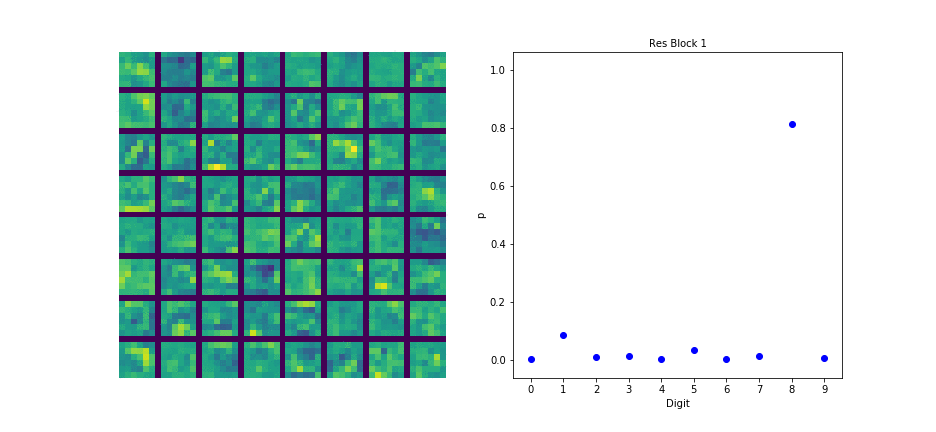

In [200]:
animate_transformation(res_hidden_activation_series, outs_series, 16, "resnet.gif", discrete=True)

The above animation shows how the state changes discretly after each application of the corresponding residual block. 
On the left, the current activations of the 64 feature maps are displayed in a 8x8 grid. On the right, the probability distribution over digits is shown, if we would apply the final readout layer directly to the current state. The animation changes over time as activity propagates through the 6 residual blocks. The number of the current block is indicated above the right plot. 

We can clearly see how both the state and the corresponding probability distribution changes discretely. It is interesting to note, that the output probability distribution repeatedly changes completely during the first few residual blocks.

## ODE-Net (Experiment 3.1)

In [201]:
ode_block = ODEBlock(ConvolutionalDynamicsFunction(64, time_dependent=True, norm_type="group"), device="cpu", 
                     intermediate_values_to_compute=np.linspace(0, 1, 100))
final_layers_ode = get_final_layers()
ode_demo = nn.Sequential(*get_downsampling_layers(), 
                                  ode_block,
                                   *final_layers_ode)
_ = train_model_cached(ode_demo, file_path="cached_models/ode_group.pth", print_model=False)
_=ode_demo.eval()

Experiment cached_models/ode_group.pth


In [202]:
out = ode_demo(img).detach().numpy()
prediction = np.argmax(out, axis=-1)
print("Prediction: {} | Label: {}".format(prediction[0], label[0]))

Prediction: 0 | Label: 0


In [203]:
hidden_state_ode_timecourse = ode_block.intermediate_values_of_last_batch
out_ode_timecourse = apply_final_to_sequence(hidden_state_ode_timecourse, final_layers_ode)

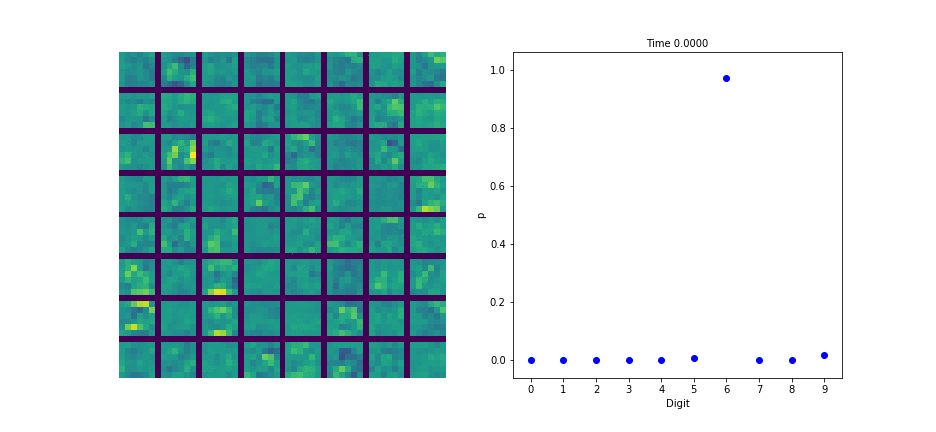

In [204]:
animate_transformation(hidden_state_ode_timecourse[:, 0, :, :, :].detach().numpy(), out_ode_timecourse, 16, "odenet.gif")

The above animation shows how the latent state of the ODE-Block evolves over time. On the left, one can see the 64 feature maps of this state organised in a 8x8 grid. On the right, one can see the probability distribution over digit labels if one would apply the final readout layer to the current latent state at that point in time. The animation changes continously as the latent state in the ODE-Block evolves over time. 

It is interesting to note that the probability distribution changes to the correct label in one smooth motion at around half of the integration time. In contrast to the residual network it moves from an incorrect label to the correct label directly without further intermediate values. 

# Sources

[1] Neural Ordinary Differential Equations; Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud (2019)    
[2] Group Normalization; Yuxin Wu Kaiming He (2018)   
[3] https://www.reddit.com/r/MachineLearning/comments/a65v5r/neural_ordinary_differential_equations_pdf/   
[4] https://github.com/rtqichen/torchdiffeq